In [0]:
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Project
# Copyright: Zhaoshuo Li, Ding Hao, Mingyi Zheng
!pip install tensorboardX visdom image_slicer
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Dataset
#from torchvision import transforms
import torchvision.transforms.functional as TF
from albumentations import *
import copy
import numpy as np
import random
from tensorboardX import SummaryWriter

#import transforms
from dataset import *
from visualization import *
from label_conversion import *
from dice_loss import *
from model_trainning import *
from model_from_ternaus import *
from deeplabv3p_resnet_super_label import SuperLabelDeepLabv3_plus
from unet import *

from google.colab import drive
drive.mount('/mydrive')

Drive already mounted at /mydrive; to attempt to forcibly remount, call drive.mount("/mydrive", force_remount=True).


In [0]:
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


# Seed pytorch and numpy and random

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pretrain_seed = 128

## Hyperparameters

In [0]:
train_batch_size = 10
validation_batch_size=10
learning_rate = 0.001
weight_decay = 5e-4
num_epochs = 30
num_class = 12
num_superclasses = 2
super2sub = [[0,4,5,6,10],[1,2,3,7,8,9,11]]
num_filters = 64

In [0]:
#dice_loss = BatchWeightDICELoss()
weights = torch.ones((num_class,1)).to(device = device)
dice_loss = SuperLabelDICELoss(weights,_lambda=0.5) 
#dice_loss = DICELoss(weights)

## Visualization

In [0]:
# Initialize the visualization environment
writer = SummaryWriter()

## AlbuNet

In [0]:
#initialize model
model = SuperLabelAlbuNet(num_super_class = num_superclasses, num_classes=num_class, num_filters=num_filters, pretrained=True, is_deconv=True, super2sub = super2sub)
   
model.to(device)

SuperLabelAlbuNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

## Optimizer and Scheduler and loss

In [0]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

## Baseline Unet16 (unet with vgg16 backbone not pretrained), without augmentation.

In [0]:
# IMPORTANT!
# must seed the same value each time when training a new network
seed = 256
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

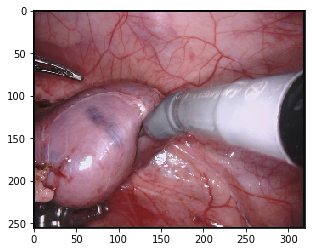

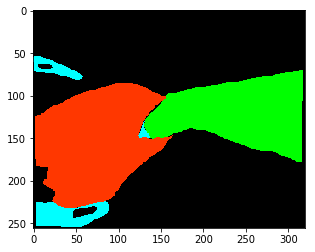

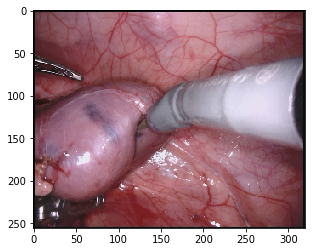

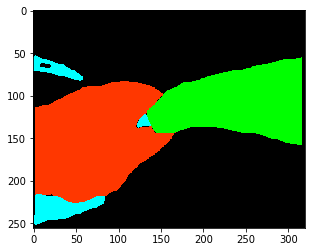

In [0]:
# define transform
image_aug = Compose([
    Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5),p=1),
])
train_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "train_min", transform_image=image_aug)
validation_dataset = MICCAIDataset(data_path = "/mydrive/My Drive/Colab Notebooks/data/",data_type = "validation_min", transform_image=image_aug)
label_converter = LabelConverter(data_path = "/mydrive/My Drive/Colab Notebooks/data/")

# # show one example
img,label = (train_dataset[0]['img'],train_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

# show one example
img,label = (validation_dataset[0]['img'],validation_dataset[0]['label'])
imshow(img.permute(1,2,0),denormalize=True)
colorlabel = train_dataset.label_converter.label2color(label.permute(1,2,0))
imshow(colorlabel)

In [0]:
# intialize the dataloader
train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

## Start training

In [15]:
best_model_wts, best_acc = run_training(model,device,num_class,scheduler,optimizer,dice_loss,num_epochs,train_generator,train_dataset,validation_generator,validation_dataset,writer,"/mydrive/My Drive/Colab Notebooks/min_albunet.pt")

Training Started!

EPOCH 1 of 30

Training Loss: 1.0992
0 Class, True Pos 10901673.0, False Pos 9479432.0, False Neg 5884575.0, Num Pixel 16786248.0, Dice score 0.59
1 Class, True Pos 2834024.0, False Pos 4367069.0, False Neg 522358.0, Num Pixel 3356382.0, Dice score 0.54
2 Class, True Pos 84064.0, False Pos 385190.0, False Neg 1601449.0, Num Pixel 1685513.0, Dice score 0.08
3 Class, True Pos 1010.0, False Pos 54804.0, False Neg 784051.0, Num Pixel 785061.0, Dice score 0.00
4 Class, True Pos 12892.0, False Pos 48036.0, False Neg 6292193.0, Num Pixel 6305085.0, Dice score 0.00
5 Class, True Pos 881966.0, False Pos 5118302.0, False Neg 3394193.0, Num Pixel 4276159.0, Dice score 0.17
6 Class, True Pos 2186.0, False Pos 721101.0, False Neg 133369.0, Num Pixel 135555.0, Dice score 0.01
7 Class, True Pos 21820.0, False Pos 1391881.0, False Neg 171604.0, Num Pixel 193424.0, Dice score 0.03
8 Class, True Pos 0.0, False Pos 190216.0, False Neg 964.0, Num Pixel 964.0, Dice score 0.00
9 Class, Tr